In [1]:
import io
from itertools import product
import logging; L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import re
import yaml

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [21]:
import sys
sys.path.append("../..")
import berp.trainer  # nice yaml dump defaults
from berp.models import load_model
from berp.viz.cluster import cluster_predictor
from berp.viz.trf import plot_trf_coefficients
from berp.viz.trf_em import pipeline_to_dataframe

In [4]:
workflow = "heilbron2022"
lm = "EleutherAI/gpt-neo-2.7B/n10000"
model_paradigm = "cannon_wide"
model_run = "trf-cannon_3quantiles"

montage = "biosemi128"
# If `None`, use all sensors in model fits
sensors = None

model_dir = f"../../workflow/{workflow}/results{'_' + model_paradigm if model_paradigm is not None else ''}/{lm}/{model_run}"

## Load model

In [6]:
pipe = load_model(model_dir, device="cpu")

In [7]:
print(yaml.safe_dump(pipe.get_params()))

confusion: tensor of type torch.float64, shape torch.Size([40, 40])
encoder: "TemporalReceptiveField(alpha=82468.40682196281, fit_intercept=True,\n  \
  \                     name='baf59f60a976403db080a7fc4a154857',\n               \
  \        optim=AdamSolver(n_batches=50,\n                                      \
  \  name='baf59f60a976403db080a7fc4a154857',\n                                  \
  \      random_state=RandomState(MT19937) at 0x2B739EA5AD40),\n                 \
  \      sfreq=128.0, tmax=0.75, tmin=0.0)"
encoder__alpha: 82468.40682196281
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: null
encoder__name: baf59f60a976403db080a7fc4a154857
encoder__optim: "AdamSolver(n_batches=50, name='baf59f60a976403db080a7fc4a154857',\n\
  \           random_state=RandomState(MT19937) at 0x2B739EA5AD40)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: baf5

## Prepare MNE metadata

In [8]:
if sensors is None:
    sensors = next(iter(pipe.encoders_.values())).output_names

for enc in pipe.encoders_.values():
    # TODO relax -- could be a subset. if so will need to subset/reorder later
    assert enc.output_names == sensors
    
sensors

['B22', 'D19', 'A19', 'C22', 'C10', 'C32', 'A7', 'B4']

In [9]:
info = mne.create_info(sensors, pipe.encoder.sfreq, "eeg")
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: B22, D19, A19, C22, C10, C32, A7, B4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 128.0 Hz
>

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 8


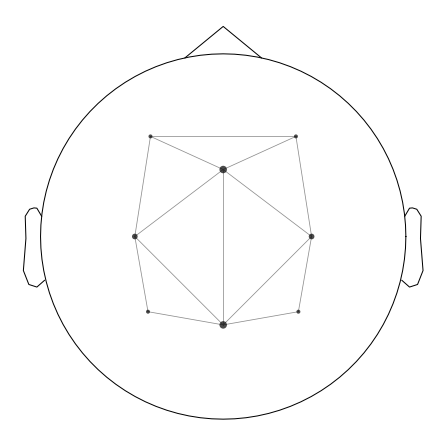

In [10]:
adjacency, ch_names = mne.channels.find_ch_adjacency(info, "eeg")
mne.viz.plot_ch_adjacency(info, adjacency, ch_names)
None

## Clean up model representation

In [11]:
ts_predictor_names, var_predictor_names = pipe.encoder_predictor_names
predictor_names = ts_predictor_names + var_predictor_names

In [18]:
trf_df = pipeline_to_dataframe(pipe)

In [19]:
def get_coef_estimates(trf_df) -> np.ndarray:
    """
    returns n_subjects * n_times * n_channels coefficient representation for
    statistical analysis
    """
    return trf_df.reset_index().set_index(["subject", "epoch_time", "sensor"]).coef.to_numpy() \
        .reshape((len(pipe.encoders_), -1, len(sensors)))

In [20]:
# Sanity check that reading the dataframe is equivalent to reading the raw coefs
t1 = np.stack([
    encoder.coef_[1, :, :]
    for encoder in pipe.encoders_.values()
])
t2 = get_coef_estimates(trf_df[trf_df.predictor_name == predictor_names[1]])
np.testing.assert_almost_equal(t1, t2)

## Test

In [58]:
def prepare_predictor_difference(p1, p2, trf_df):
    """
    compute difference p2 - p1 coefficients
    """
    df = trf_df.reset_index().set_index(["predictor_name", "subject", "epoch_time", "sensor"])
    df = df.loc[[p1, p2]].coef
    ret = (df.loc[p2] - df.loc[p1]).reset_index()
    ret["predictor_name"] = f"{p2} - {p1}"
    
    return ret

In [24]:
def cluster_predictor_(predictor_df, *args, **kwargs):
    if isinstance(predictor_df, str):
        predictor_df = trf_df[trf_df.predictor_name == predictor_df]
    return cluster_predictor(predictor_df, *args, info=info, **kwargs)

## Plot results

### Main effects

  0%|          | 0/12 [00:00<?, ?predictor/s]

var_recognition_onset_0
Using a threshold of 2.100922
stat_fun(H1): min=-8.975772 max=9.228945
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

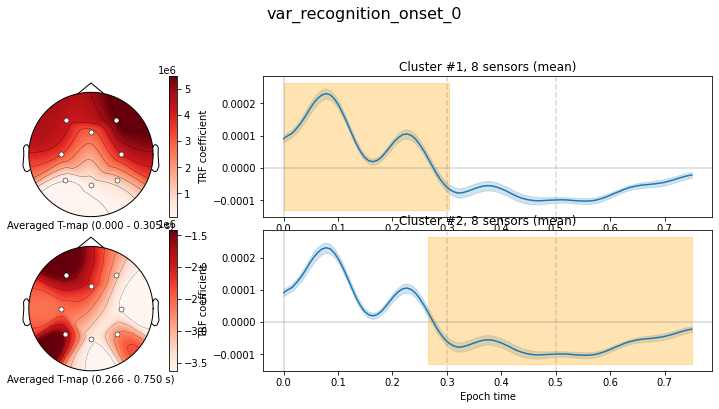

var_recognition_onset_1
Using a threshold of 2.100922
stat_fun(H1): min=-6.530482 max=5.776977
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

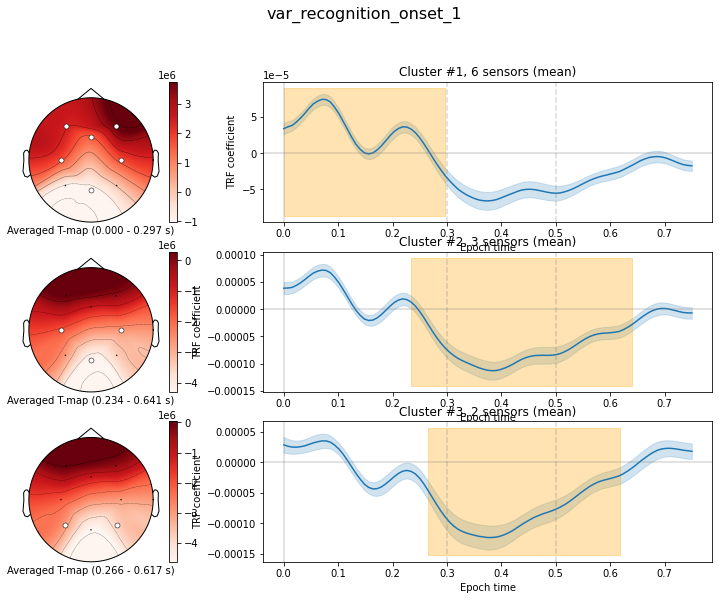

var_recognition_onset_2
Using a threshold of 2.100922
stat_fun(H1): min=-4.938421 max=5.327492
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

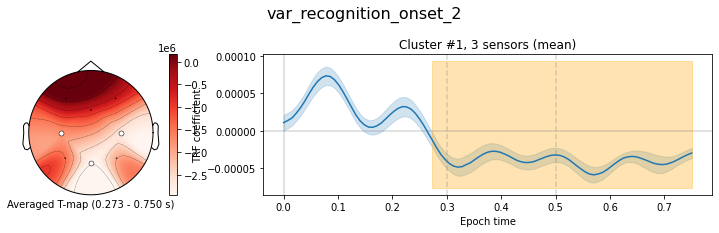

var_recognition_onset_3
Using a threshold of 2.100922
stat_fun(H1): min=-5.944455 max=6.459001
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

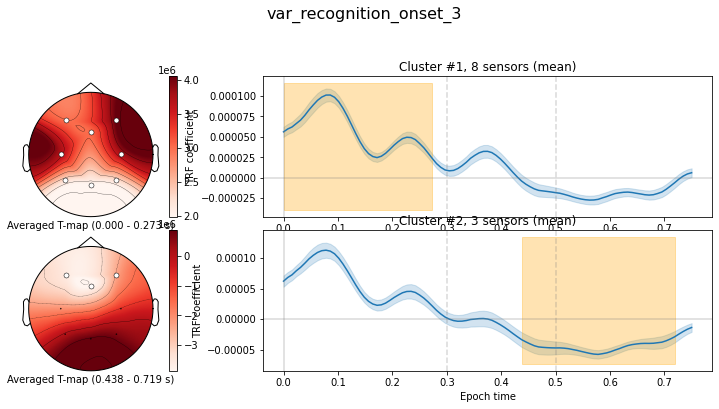

var_word_frequency_0
Using a threshold of 2.100922
stat_fun(H1): min=-6.355260 max=4.341262
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

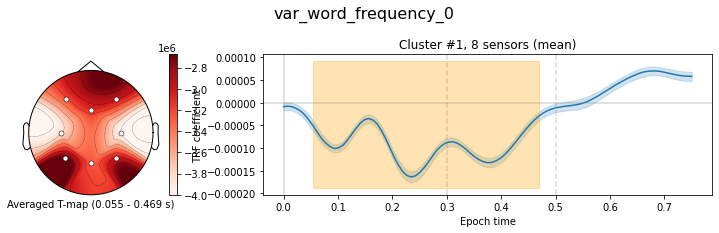

var_word_frequency_1
Using a threshold of 2.100922
stat_fun(H1): min=-6.933221 max=4.015709
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

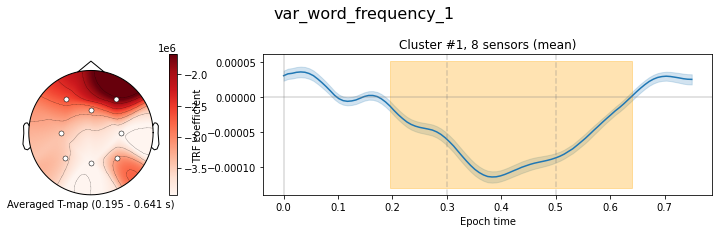

var_word_frequency_2
Using a threshold of 2.100922
stat_fun(H1): min=-7.439808 max=5.515491
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

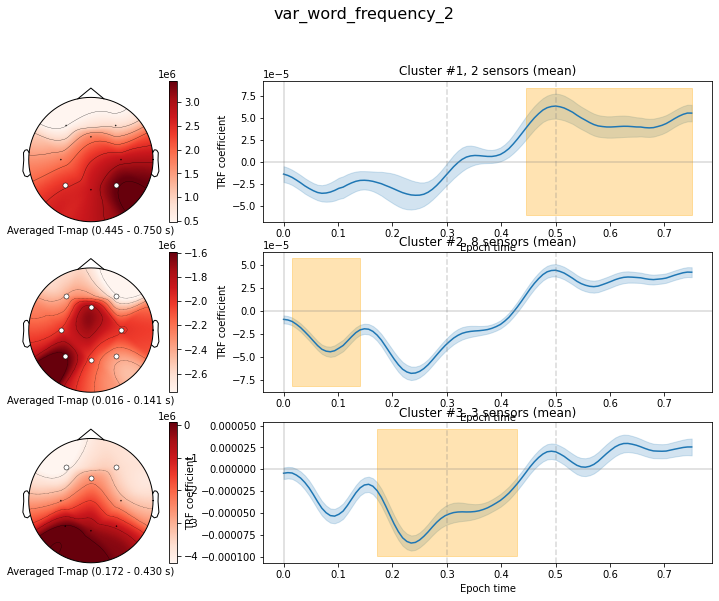

var_word_frequency_3
Using a threshold of 2.100922
stat_fun(H1): min=-5.661751 max=3.179493
Running initial clustering …
Found 8 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

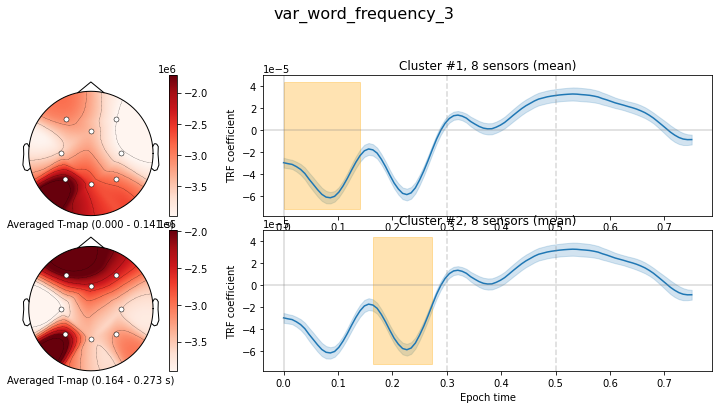

var_word_surprisal_0
Using a threshold of 2.100922
stat_fun(H1): min=-7.530097 max=1.783713
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

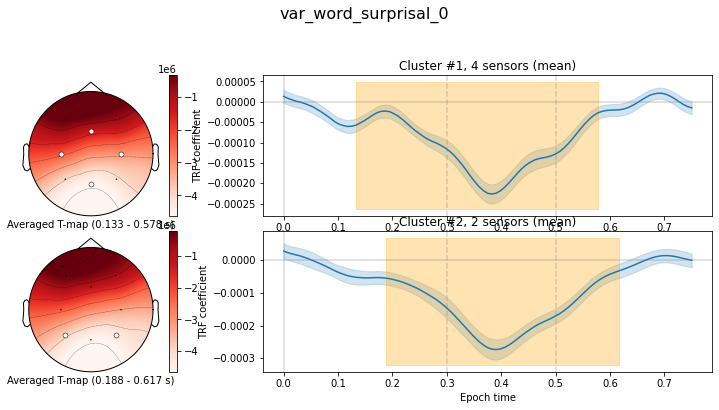

var_word_surprisal_1
Using a threshold of 2.100922
stat_fun(H1): min=-8.472322 max=6.684527
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

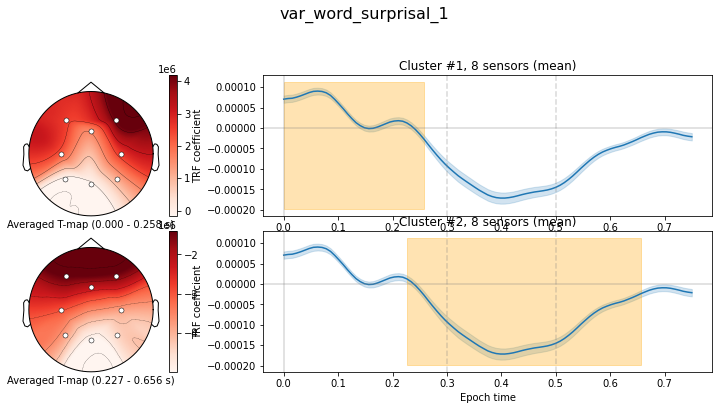

var_word_surprisal_2
Using a threshold of 2.100922
stat_fun(H1): min=-3.543077 max=4.464408
Running initial clustering …
Found 9 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

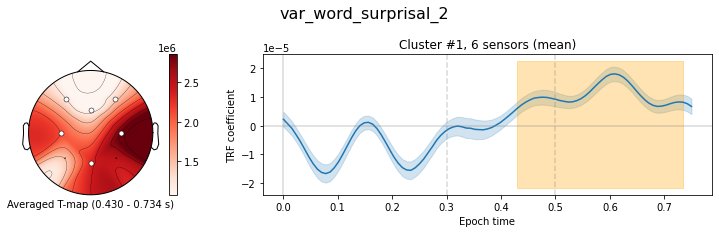

var_word_surprisal_3
Using a threshold of 2.100922
stat_fun(H1): min=-6.602186 max=5.973168
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

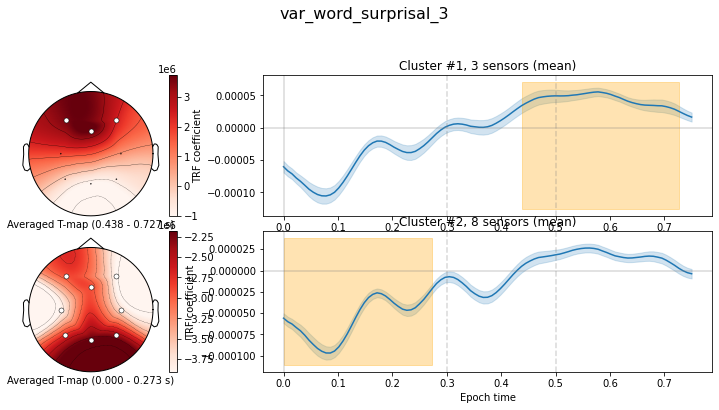

<Figure size 432x288 with 0 Axes>

In [43]:
for name in tqdm(sorted(var_predictor_names), unit="predictor"):
    print(name)
    cluster_predictor_(name, n_jobs=2)

### Cannon differences

In [57]:
cannon_df = trf_df[trf_df.predictor_name.str.contains(r"_\d+$")].copy()
cannon_df[["base_predictor", "quantile"]] = cannon_df.predictor_name.str.rsplit("_", n=1, expand=True)
cannon_df["quantile"] = cannon_df["quantile"].astype(int)
cannon_df

,predictor,lag,sensor,coef,epoch_time,predictor_name,sensor_name,base_predictor,quantile
subject,,,,,,,,,
1,13,0,0,0.000030,0.00,var_recognition_onset_0,B22,var_recognition_onset,0
1,13,0,1,0.000013,0.00,var_recognition_onset_0,D19,var_recognition_onset,0
1,13,0,2,0.000040,0.00,var_recognition_onset_0,A19,var_recognition_onset,0
1,13,0,3,-0.000090,0.00,var_recognition_onset_0,C22,var_recognition_onset,0
1,13,0,4,0.000008,0.00,var_recognition_onset_0,C10,var_recognition_onset,0
...,...,...,...,...,...,...,...,...,...
19,24,96,3,0.000152,0.75,var_word_surprisal_3,C22,var_word_surprisal,3
19,24,96,4,0.000025,0.75,var_word_surprisal_3,C10,var_word_surprisal,3
19,24,96,5,0.000077,0.75,var_word_surprisal_3,C32,var_word_surprisal,3


  0%|          | 0/3 [00:00<?, ?predictor/s]

var_recognition_onset
Using a threshold of 2.100922
stat_fun(H1): min=-2.811449 max=6.184029
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

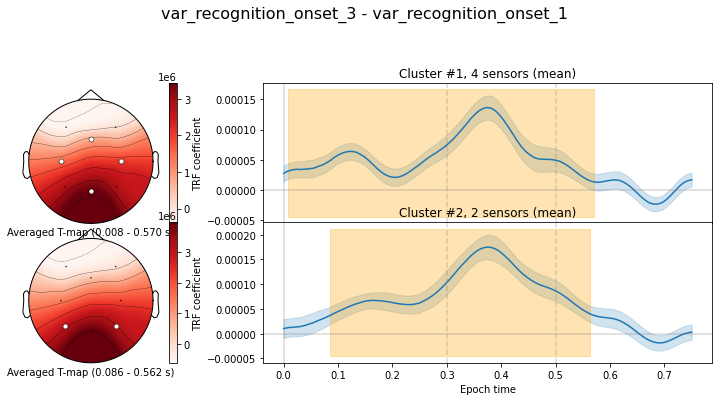

var_word_frequency
Using a threshold of 2.100922
stat_fun(H1): min=-6.003293 max=6.007929
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

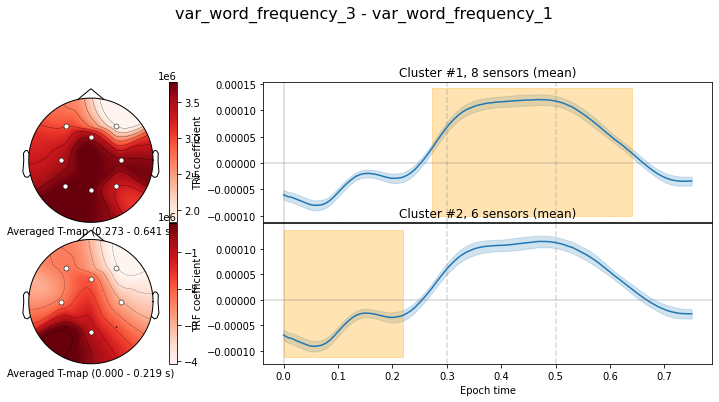

var_word_surprisal
Using a threshold of 2.100922
stat_fun(H1): min=-8.596844 max=6.791726
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

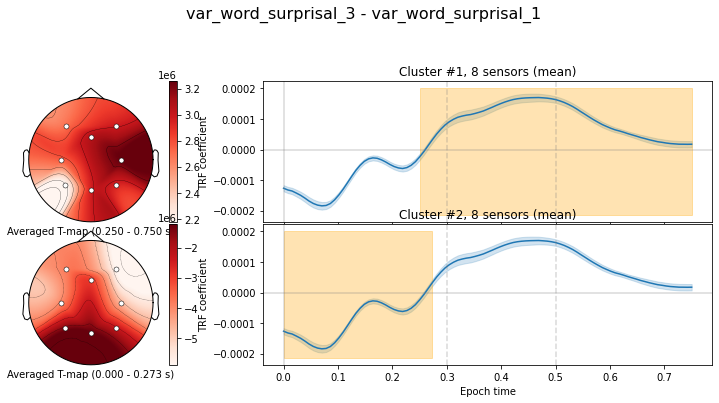

<Figure size 432x288 with 0 Axes>

In [60]:
max_quantile, min_quantile = cannon_df["quantile"].max(), 1
for name in tqdm(sorted(cannon_df.base_predictor.unique()), unit="predictor"):
    print(name)
    cluster_predictor_(
        prepare_predictor_difference(f"{name}_{min_quantile}", f"{name}_{max_quantile}", cannon_df),
        n_jobs=2)
    None